Train and score a boosted decision tree model using [LightGBM Python package](https://github.com/Microsoft/LightGBM) from Microsoft, which is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms.  

In [1]:
import os
import sys
import math
import itertools
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb 

In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [3]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Parameters of GBM model
params = {
    'num_leaves': 60, #80,
    'objective': 'regression',
    'min_data_in_leaf': 200, #200,
    'learning_rate': 0.02, #0.02,
    'feature_fraction': 0.6, #0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16
}
params = {
    'num_leaves': 50, #100, #80,
    'objective': 'mape', ''#'regression',
    'min_data_in_leaf': 200, #200,
    'learning_rate': 0.002, #0.002, #0.02 #0.02,
    'feature_fraction': 0.9, #0.6, #0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    #'metric': 'l2',
    'num_threads': 16
}
MAX_ROUNDS = 100 #100 #4000 

# Lags and categorical features
lags = [2,3,4] #[2,3,4]
lags_str = [str(x) for x in lags]
#categ_fea = [''.join(res) for res in itertools.product(['deal_lag', 'feat_lag'], lags_str)]
categ_fea = ['deal', 'feat']
categ_fea = ['store', 'brand'] + categ_fea

first_week_start = pd.to_datetime('1989-09-07 00:00:00') 

In [4]:
# Utility functions
def week_of_month(dt):
    """ 
    Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + '_lag' + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

def moving_averages(df, start_step, window_size=None):
    """
    Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size == None: # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + '_mean'
    return fea

def create_features(df):
    """
    Create features used for model training.
    
    Args:
        df (Dataframe): Time series data of a certain store and brand
    
    Returns:
        fea_all (Dataframe): All features for the specific store and brand
    """
    lagged_fea = lagged_features(df[['move']], lags)
    moving_avg = moving_averages(df[['move']], 2, 10)
    fea_columns = ['brand' , 'store', 'week', 'week_of_month', 'day', 'profit', 'deal' , 'feat', 'move']
    #fea_columns = fea_columns + ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']
    fea_all = pd.concat([df[fea_columns], lagged_fea, moving_avg], axis=1)
    return fea_all

def make_predictions(df, model):
    """
    Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({'move': model.predict(df.drop('move', axis=1))})
    predictions['move'] = predictions['move'].apply(lambda x: round(x))
    return pd.concat([df[['brand', 'store', 'week']].reset_index(drop=True), predictions], axis=1)

def evaluate(pred, actual):
    """
    Compute MAPE value of the forecast.
    
    Args:
        pred (Dataframe): Predicted sales
        actual (Dataframe): Actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(pred['move'], actual['move'])*100

In [5]:
# Train and predict for all forecast rounds
pred_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS): 
    print('---- Round ' + str(r+1) + ' ----')
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    train_df.drop('logmove', axis=1, inplace=True)
    print(train_df.head(3))
    print('')
    # Fill missing values
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: first_week_start + datetime.timedelta(days=(x-bs.TRAIN_START_WEEK)*7))
    data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)
    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(['store','brand']). \
                           apply(lambda x: create_features(x))
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    # Drop rows with NaN values
    train_fea.dropna(inplace=True)
    print(train_fea.head(1))
    print('')
    print('Training and predicting models...')
    evals_result = {} # to record eval results for plotting
    dtrain = lgb.Dataset(
                train_fea.drop('move', axis=1, inplace=False), 
                label = train_fea['move']
    )
    # Train GBM model
    bst = lgb.train(
        params, 
        dtrain, 
        num_boost_round = MAX_ROUNDS,
        valid_sets = [dtrain], 
        categorical_feature = categ_fea,
        early_stopping_rounds = 125, 
        evals_result = evals_result,
        verbose_eval = 20
    )
    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = test_fea.groupby(['store','brand']). \
                    apply(lambda x: make_predictions(x, bst)). \
                    reset_index(drop=True)
            
    print(pred)
    print('')
    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['move'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)
    metric_value = evaluate(pred, test_df)
    print('')
    print('MAPE of current round is {}'.format(metric_value))
    print('')
    # Keep the predictions and accuracy
    pred_all.append(pred)
    metric_all.append(metric_value)

---- Round 1 ----
   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6204

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0  

/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['brand', 'deal', 'feat', 'store']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	training's mape: 0.761025
[40]	training's mape: 0.742859
[60]	training's mape: 0.725362
[80]	training's mape: 0.70905
[100]	training's mape: 0.693508
Did not meet early stopping. Best iteration is:
[100]	training's mape: 0.693508
      brand  store  week  move
0         1      2   137  2161
1         1      2   138  2161
2         2      2   137  2193
3         2      2   138  2282
4         3      2   137  1359
5         3      2   138  1362
6         4      2   137  1646
7         4      2   138  1582
8         5      2   137  1994
9         5      2   138  2055
10        6      2   137  1289
11        6      2   138  1242
12        7      2   137  1385
13        7      2   138  1375
14        8      2   137  1190
15        8      2   138  1201
16        9      2   137  1330
17        9      2   138  1325
18       10      2   137  2044
19       10      2   138  2025
20       11      2   137  1985
21       11      2   138  2083
22        1      5   137  2153
23        1      5   

/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['brand', 'deal', 'feat', 'store']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	training's mape: 0.759219
[40]	training's mape: 0.741191
[60]	training's mape: 0.723989
[80]	training's mape: 0.70795
[100]	training's mape: 0.692696
Did not meet early stopping. Best iteration is:
[100]	training's mape: 0.692696
      brand  store  week  move
0         1      2   139  2051
1         1      2   140  2053
2         2      2   139  2038
3         2      2   140  2023
4         3      2   139  1437
5         3      2   140  1437
6         4      2   139  1804
7         4      2   140  1819
8         5      2   139  2428
9         5      2   140  2457
10        6      2   139  1491
11        6      2   140  1806
12        7      2   139  1516
13        7      2   140  1478
14        8      2   139  1237
15        8      2   140  1236
16        9      2   139  1138
17        9      2   140  1135
18       10      2   139  2051
19       10      2   140  2051
20       11      2   139  1504
21       11      2   140  1493
22        1      5   139  1894
23        1      5   

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6358

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6578

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6875

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  move_lag4  move_mean  
4     8256.0     8256.0     8256

In [6]:
np.mean(metric_all)

65.8627763644255

Plot feature importances...


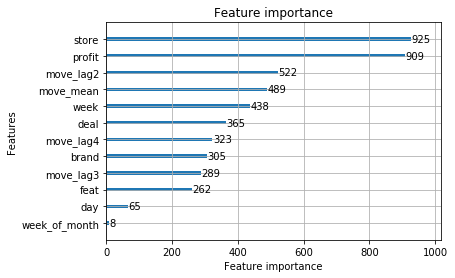

In [9]:
import matplotlib.pyplot as plt

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()